In [1]:
import os
import urllib
import pandas as pd
import numpy as np
from numpy.random import uniform, binomial
from sklearn.model_selection import KFold
import math
import matplotlib.pyplot as plt
import time

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_probability as tfp
tfd = tfp.distributions

# To remove WARNINGS from saving the models without compiling them first
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#print(tf.__version__)
#print(tf.test.gpu_device_name())

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

#Working with CPU for now...

Num GPUs Available:  0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
from __future__ import division
import datetime
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from random import seed
#from .UCI_loader import unnormalise_cat_vars


# TODO return mean and std for variables + train test split

"""
def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        try:
            response = urllib2.urlopen(addr)
        except:
            response = urllib3.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "w")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."
"""

def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        
        response = urllib.request.urlopen(addr)

        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."

def get_my_COMPAS(rseed=0, separate_test=True, test_ratio=0.2, save_dir='../data/'):
    """
        The adult dataset can be obtained from: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
        The code will look for the data file in the present directory, if it is not found, it will download them from GitHub.
    """

    SEED = rseed
    seed(SEED)
    np.random.seed(SEED)

    their_FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"]
    FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "c_charge_degree", "is_recid", "priors_count",
                               "time_served"]  # features to be used for classification
    CONT_VARIABLES = ["priors_count",
                      "time_served"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "two_year_recid"  # the decision variable


    COMPAS_INPUT_FILE = save_dir + "compas-scores-two-years.csv"
    check_data_file(COMPAS_INPUT_FILE)

    # load the data and get some stats
    df = pd.read_csv(COMPAS_INPUT_FILE)
    df = df.dropna(subset=["days_b_screening_arrest"])  # dropping missing vals

    # convert to np array
    data = df.to_dict('list')
    for k in data.keys():
        data[k] = np.array(data[k])

    dates_in = data['c_jail_in']
    dates_out = data['c_jail_out']
    # this measures time in Jail
    time_served = []
    for i in range(len(dates_in)):
        di = datetime.datetime.strptime(dates_in[i], '%Y-%m-%d %H:%M:%S')
        do = datetime.datetime.strptime(dates_out[i], '%Y-%m-%d %H:%M:%S')
        time_served.append((do - di).days)
    time_served = np.array(time_served)
    time_served[time_served < 0] = 0
    data["time_served"] = time_served

    """ Filtering the data """

    # These filters are the same as propublica (refer to https://github.com/propublica/compas-analysis)
    # If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
    idx = np.logical_and(data["days_b_screening_arrest"] <= 30, data["days_b_screening_arrest"] >= -30)

    # We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
    idx = np.logical_and(idx, data["is_recid"] != -1)

    # In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
    idx = np.logical_and(idx, data["c_charge_degree"] != "O")  # F: felony, M: misconduct

    # We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
    idx = np.logical_and(idx, data["score_text"] != "NA")

    # select the examples that satisfy this criteria
    for k in data.keys():
        data[k] = data[k][idx]

    y = data[CLASS_FEATURE]
    """ Feature normalization and one hot encoding """

    print
    "\nNumber of people recidivating within two years"
    print
    pd.Series(y).value_counts()
    print
    "\n"

    X = []  # empty array with num rows same as num examples, will hstack the features to it
    X_dims = []

    feature_names = []
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            # vals = preprocessing.scale(vals, axis=0, with_mean=True, with_std=True)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            X_dims.append(1)

        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
            enc.fit(vals.reshape(-1, 1))
            vals = enc.transform(vals.reshape(-1, 1)).todense()
            X_dims += [vals.shape[1]]*vals.shape[1]

        # add to learnable features
        X.append(vals)

        if attr in CONT_VARIABLES:  # continuous feature, just append the name
            feature_names.append(attr)
        else:  # categorical features
            if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in enc.categories_:  # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))

    X = np.array(np.concatenate(list(X), axis=1))
    X_dims = np.array(X_dims)

    if separate_test:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=rseed, shuffle=True)

        x_means, x_stds = X_train.mean(axis=0), X_train.std(axis=0)
        x_means[X_dims>1] = 0
        x_stds[X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X_train - x_means) / x_stds).astype(np.float32)
        x_test = ((X_test - x_means) / x_stds).astype(np.float32)

        return x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims
    else:
        x_means, x_stds = X.mean(axis=0), X.std(axis=0)
        print(X_dims.shape, x_means.shape)
        x_means[:,X_dims>1] = 0
        x_stds[:,X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X - x_means) / x_stds).astype(np.float32)

        return x_train, x_means, x_stds, y, feature_names, X_dims


def join_compas_targets(x_train, x_test, y_train, y_test, X_dims):
    # output from get method is onehot so we need to flatten and append 2
    input_dim_vec = X_dims_to_input_dim_vec(X_dims)
    input_dim_vec = np.append(input_dim_vec, 2)
    enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
    enc.fit(y_train.reshape(-1, 1))

    vals_train = np.array(enc.transform(y_train.reshape(-1, 1)).todense()).astype(np.float32)
    vals_test = np.array(enc.transform(y_test.reshape(-1, 1)).todense()).astype(np.float32)

    x_train = np.concatenate([x_train, vals_train], axis=1)
    x_test = np.concatenate([x_test, vals_test], axis=1)
    return x_train, x_test, input_dim_vec


def X_dims_to_input_dim_vec(X_dims):
    """This is for our cat_Gauss VAE model"""
    input_dim_vec = []
    i = 0
    while i < len(X_dims):
        input_dim_vec.append(X_dims[i])
        i += X_dims[i]
    return np.array(input_dim_vec)

#"""
def input_dim_vec_to_X_dims(input_dim_vec):
    # This is for our cat_Gauss VAE model
    X_dims = []
    for i in input_dim_vec:
        for ii in range(i):
            X_dims.append(i)
    return np.array(X_dims)
#"""

## Reading data

In [4]:
# For Default credit

input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2]
width = 350
depth = 3
latent_dim = 8

# For all tabular data sets
names = ['wine', 'default_credit', 'compas', 'lsat']
widths = [350, 350, 350, 350] # Bigger than VAE because the task of modelling all conditionals is more complex
depths = [3, 3, 3, 3] # We go deeper because we are using residual models
latent_dims = [6, 8, 4, 4]
under_latent_dims = [6, 8, 4, 4] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]
under_latent_dims2 = [4, 6, 3, 3] # following the original paper we set dim(u) = dim(z) with d>r [r is true manifold dim]

dname = 'default_credit'
print(dname)


default_credit


In [5]:
# Load the datasets in UCI
def load_UCI(dset_name, splits=10, seed=0, separate_targets=True, save_dir='data/'):
    mkdir(save_dir)

    if dset_name == 'wine':
        if not os.path.isfile(save_dir+'winequality-red.csv'):
            urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                               filename=save_dir+'winequality-red.csv')
        data = pd.read_csv(save_dir+'winequality-red.csv', header=1, delimiter=';').values
        y_idx = [-1]

    elif dset_name == 'default_credit':
        if not os.path.isfile(save_dir + 'default of credit card clients.xls'):
            urllib.request.urlretrieve(
                "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
                filename=save_dir + 'default of credit card clients.xls')
        data = pd.read_excel(save_dir + 'default of credit card clients.xls', header=[0, 1], index_col=0, # delimiter="\s+"
                             ).values
        y_idx = [-1]  # OK


    else:
        raise Exception('Dataset name doesnt match any known datasets.')

    np.random.seed(seed)
    data = data[np.random.permutation(np.arange(len(data)))] #Shuffle the data
    
    kf = KFold(n_splits=splits)
    for j, (train_index, test_index) in enumerate(kf.split(data)):

        # Not sure what separate targets is
        if separate_targets:
            x_idx = list(range(data.shape[1]))
            for e in y_idx:
                x_idx.remove(x_idx[e])

            x_idx = np.array(x_idx)
            y_idx = np.array(y_idx)
            x_train, y_train = data[train_index, :], data[train_index, :]
            x_train, y_train = x_train[:, x_idx], y_train[:, y_idx]
            x_test, y_test = data[test_index, :], data[test_index, :]
            x_test, y_test = x_test[:, x_idx], y_test[:, y_idx]

            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)
            y_means, y_stds = y_train.mean(axis=0), y_train.std(axis=0)

            y_stds[y_stds < 1e-10] = 1
            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            y_train = ((y_train - y_means) / y_stds).astype(np.float32)

            x_test = ((x_test - x_means) / x_stds).astype(np.float32)
            y_test = ((y_test - y_means) / y_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds

        else:
            x_train, x_test = data[train_index, :], data[test_index, :]
            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)

            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            x_test = ((x_test - x_means) / x_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds

def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)

def unnormalise_cat_vars(x, x_means, x_stds, input_dim_vec):
    """
    Converts a feature vector with continous values into a vector with continous and discrete values for those 
    which come from a categorical class.
    """
    input_dim_vec = np.array(input_dim_vec)
    unnorm_x = np.multiply(x, x_stds) + x_means

    fixed_unnorm = unnorm_x.round()
    fixed_unnorm -= fixed_unnorm.min(axis=0).reshape([1, fixed_unnorm.shape[1]])  # this sets all mins to 0
    for idx, dims in enumerate(input_dim_vec):
        if dims > 1:
            vec = fixed_unnorm[:, idx]
            vec[vec > dims - 1] = dims - 1
            fixed_unnorm[:, idx] = vec

    x[:, input_dim_vec > 1] = fixed_unnorm[:, input_dim_vec > 1]
    return x


## Recognition (Encoder)

In [6]:
"""
The arguments sent to the different keras layers are there to mimic the Torch layers in CLUE.
"""

def create_recognition_encoder(width, depth, latent_dim, input_dim_vec):
    # Tensorflow network as one big Russian doll
    nb_inputs = sum(input_dim_vec)
    inputs = keras.Input(shape=(nb_inputs,))
    #inputs = keras.Input(shape=(None,nb_inputs))
    input = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs))) \
                         (inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU(alpha=0.01)(input)
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

        # Skip connection 
        x = x + input

        input = x

    # Final layers
    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    outputs = layers.Dense(latent_dim*2, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

    recognition_encoder = keras.Model(inputs=inputs, outputs=outputs, name="recognition_encoder_model")
    return recognition_encoder
#recognition_encoder.summary()

#keras.utils.plot_model(encoder, "encoder.png")
#keras.utils.plot_model(recognition_encoder, "recognition.png", show_shapes=True)




## Prior network (Encoder)

In [7]:
"""
The arguments sent to the different keras layers are there to mimic the Torch layers in CLUE.
"""
def create_prior_encoder(width, depth, latent_dim, input_dim_vec):
    nb_inputs = sum(input_dim_vec)*2
    inputs = keras.Input(shape=(nb_inputs,))
    #inputs = keras.Input(shape=(None,nb_inputs))
    input = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs))) \
                         (inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU(alpha=0.01)(input)
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

        x = x + input

        input = x

    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    outputs = layers.Dense(latent_dim*2, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

    prior_encoder = keras.Model(inputs=inputs, outputs=outputs, name="prior_encoder_model")
    return prior_encoder
#prior_encoder.summary()

#keras.utils.plot_model(encoder, "encoder.png")
#keras.utils.plot_model(prior_encoder, "prior.png", show_shapes=True)


## Generator (Decoder)

In [8]:
"""
The arguments sent to the different keras layers are there to mimic the Torch layers in CLUE.
"""
def create_decoder(width, depth, latent_dim, input_dim_vec):
    nb_inputs = latent_dim
    inputs = keras.Input(shape=(nb_inputs,))
    input = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/nb_inputs), math.sqrt(1/nb_inputs))) \
                         (inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU(alpha=0.01)(input)
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Dense(width, use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)
        x = x + input

        input = x

    x = layers.LeakyReLU(alpha=0.01)(x)
    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    outputs = layers.Dense(sum(input_dim_vec), use_bias=True, \
                         kernel_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width)), \
                         bias_initializer = tf.keras.initializers.RandomUniform(-math.sqrt(1/width), math.sqrt(1/width))) \
                         (x)

    decoder = keras.Model(inputs=inputs, outputs=outputs, name="decoder_model")
    return decoder

#decoder.summary()

#keras.utils.plot_model(model, "decoder_model.png")
#keras.utils.plot_model(decoder, "generator.png", show_shapes=True)


## Masker

In [9]:
class top_masker_tensorflow:
    """
    Returned mask is sampled from component-wise independent Bernoulli
    distribution with probability of component to be unobserved p.
    Such mask induces the type of missingness which is called
    in literature "missing completely at random" (MCAR).
    If some value in batch is missed, it automatically becomes unobserved.
    """
    def __init__(self, p):
        self.p = p

    def __call__(self, batch):
        """
        Parameters:
            - batch is a numpy array with as many rows as batch_size and as many columns as features
        
        Returned:
       
            - mask is a float32 tensor
        
        The mask seems to be random
        """
        # Generate one uniform number for each row (1xrow numpy matrix)
        pp = uniform(low=0.0, high=self.p, size=batch.shape[0]) 
        pp = np.expand_dims(pp, axis=1) # Put the number in 1x1 matrices in a 1x#row matrix
        pp = np.repeat(pp, batch.shape[1], axis=1) # Repeat the number across each row
        nan_mask = tf.math.is_nan(batch) # If nan => should be unobserved i.e. boolean True
        
        # Generate Bernoulli samples (0 or 1) from pp i.e. for each sample in batch determine if a feature is
        # observed or hidden.
        bernoulli_mask_numpy = binomial(1, pp, size=None) 
        bernoulli_mask = tf.convert_to_tensor(tf.cast(bernoulli_mask_numpy, tf.bool))
        mask = tf.math.logical_or(bernoulli_mask, nan_mask) # Logical or between bernoulli and nan mask
        
        # Logical not to invert the mask (This is done in CLUE)
        # Mask is converted to a boolean tensor with floats for element wise multiplication with the batch
        # which is done in apply mask
        # (True => 0, False => 1)
        
        #TODO: The logical_not might be unnecessary as the probability of getting a true or false is equal.
        #      No mirror the Torch code however I did this but it can perhaps be removed later...
        return tf.cast(tf.math.logical_not(mask), dtype=tf.float32)

## Utils

In [10]:
def gauss_cat_to_flat_mask(mask, input_dim_vec):
    output = []
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            """
            tf.expand_dims (axis=1) takes mask[:, idx] (batch_size,) and 
            converts it into (64,1) e.g. [1,2,3] => [[1];[2];[3]] i.e. same as torch unsqueeze(1)
            """
            output.append(tf.expand_dims(mask[:, idx], axis=1))

        elif dim > 1: 
            """ COMMENT
            tf.expand_dims (read comment above)
            tf.ones([mask.shape[0], dim]) creates an array of batch_size x dim with ones
            oh_vec will be mask.shape[0] x dim and contain 0 or 1 on rows depending on if mask is 0 or 1.
            """
            oh_vec = tf.ones([mask.shape[0], dim]) * tf.expand_dims(mask[:, idx], axis=1)

            output.append(oh_vec)
        else:
            raise ValueError('Error, invalid dimension value')
    return tf.concat(output, axis=1)


def gauss_cat_to_flat(x, input_dim_vec):
    """
    Parameters:
        - x: numpy array
        - input_dim_vec: list e.g. [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2] credit
    Returns:
        - numpy array 
        
    Example:
        
        x:
             [-0.52121574  0.          2.          1.          1.2496392   0.01383046
              0.1105278   1.8173771   0.18815508  0.2341654   1.9953084   0.2038664
              0.31341553  0.31455126  0.32473356  0.4501966   0.45570025  0.0774322
             -0.2517514  -0.1535475   0.03951775 -0.31174627 -0.12532774  0.        ]
        
        input_dim_vec:
            [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2]
        
        return:
             [-0.52121574  1.          0.          0.          0.          1.
              0.          0.          1.          0.          1.2496392   0.01383046
              0.1105278   1.8173771   0.18815508  0.2341654   1.9953084   0.2038664
              0.31341553  0.31455126  0.32473356  0.4501966   0.45570025  0.0774322
             -0.2517514  -0.1535475   0.03951775 -0.31174627 -0.12532774  1.
              0.        ]
    
    """
    output = []
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            output.append(tf.expand_dims(x[:, idx], axis=1))
        elif dim > 1:
            oh_vec = tf.one_hot(x[:, idx], dim) # Returns one hot encoding 0 with dim 2 -> 1 0, 1 -> 0 1
            output.append(oh_vec)
        else:
            raise ValueError('Error, invalid dimension value')
    return tf.concat(output, axis=1).numpy()


## CLASS VAEAC and loss and training

In [11]:
class VAEAC_gauss_cat(tf.keras.Model):
    def __init__(self, width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer, save_model):
        super(VAEAC_gauss_cat, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim_vec = input_dim_vec
        self.recognition_encoder = create_recognition_encoder(width, depth, latent_dim, input_dim_vec)
        self.prior_encoder = create_prior_encoder(width, depth, latent_dim, input_dim_vec)
        self.decoder = create_decoder(width, depth, latent_dim, input_dim_vec)
        self.sigma_mu = 1e4
        self.sigma_sigma = 1e-4
        self.vlb_scale = 1 / len(self.input_dim_vec)
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.save_model = save_model
        self.lr = lr
        

    # Inspiration taken from 
    # https://github.com/joocxi/tf2-VAEAC/blob/d2b1bbc258ec77ee0975ea7eb68e63c4efcda6f0/model/vaeac.py
    def prior_regularizer(self, prior):

        mu = tf.reshape(prior.mean(), (self.batch_size, -1))
        sigma = tf.reshape(prior.scale, (self.batch_size, -1))

        mu_regularizer = -tf.reduce_sum(tf.square(mu), -1) / (2 * self.sigma_mu ** 2)
        sigma_regularizer = tf.reduce_sum((tf.math.log(sigma) - sigma), -1) * self.sigma_sigma
        return mu_regularizer + sigma_regularizer

    def apply_mask(self, x, mask):
        return x * mask

    def reconstruction_loss(self, x, y):
        log_prob_vec = []
        cum_dims = 0
        reshape_dim = self.batch_size
        for idx, dims in enumerate(self.input_dim_vec):
            if dims == 1:
                # Gaussian_case
                log_prob_vec.append(tf.expand_dims(-(x[:, cum_dims] - y[:, cum_dims])**2, 1))
                
                cum_dims += 1

            elif dims > 1:
                # if x.shape[1] == y.shape[1]:
                #    raise Exception('Input and target seem to be in flat format. Need integer cat targets.'

                cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE, from_logits = True)
                cat_cross_entropy = -cce(tf.cast(y[:, cum_dims:cum_dims + dims], dtype=tf.int64), x[:, cum_dims:cum_dims + dims])
                
                log_prob_vec.append(tf.expand_dims(cat_cross_entropy, 1))
                cum_dims += dims

            else:
                raise ValueError('Error, invalid dimension value')

        log_prob_vec = tf.reshape(log_prob_vec, [reshape_dim, len(self.input_dim_vec)])
        log_prob_vec = tf.reduce_sum(log_prob_vec, axis= -1) # Do I want this? 
                                                                 # Yes vlb in original code does this when return
        return log_prob_vec

    """
    def generate_samples_params(self, inputs, masks, sample=1):

        #Takes a model and 

        # (batch_size, width, height, channels)
        observed_inputs = self.make_observed_inputs(inputs, masks)
        # (batch_size, width, height, 2*channels)
        observed_inputs_with_masks = tf.concat([observed_inputs, masks], axis=-1)

        prior_params = self.prior_net(observed_inputs_with_masks)

        prior_distribution = tfd.Normal(
          loc=prior_params[..., :256],
          scale=tf.clip_by_value(
            tf.nn.softplus(prior_params[..., 256:]),
            1e-3,
            tf.float32.max),
          name="priors")

        samples_params = []
        for i in range(sample):
          latent = prior_distribution.sample()
          sample_params = self.generative_net(latent)
          samples_params.append(sample_params)
        return tf.stack(samples_params, axis=1)
    """
    
    # TODO Implement correctly
    """
    def generate_sample(self, sample=1):
        if(self.proposal_distribution == None):
            raise Exception('Network has no proposal distribution. Train it first')
        else:
            latent = proposal_distribution.sample()

            generative_params = self.decoder(latent)
        
            return generative_params
    """

def eval(model, x_batch, x_flat, x_masked, mask):

    x_flat = tf.convert_to_tensor(x_flat)

    prior_params = model.prior_encoder(x_masked)
    #prior_params = model.prior_encoder(x_masked, training = True)
    #prior_params = model.prior_encoder(x_masked, training = False)

    proposal_params = model.recognition_encoder(x_flat)
    #proposal_params = model.recognition_encoder(x_flat, training = True)
    #proposal_params = model.recognition_encoder(x_flat, training = False)

    # Essentially CLUEs normal_parse_params
    prior_distribution = tfd.Normal(
      loc=prior_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(prior_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="priors")

    proposal_distribution = tfd.Normal(
      loc=proposal_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="proposal")

    z_sample = proposal_distribution.loc

    rec_params = model.decoder(z_sample)
    #rec_params = model.decoder(z_sample, training = True)
    #rec_params = model.decoder(z_sample, training = False)
    
    regularizer = model.prior_regularizer(prior_distribution)

    rec_loss = model.reconstruction_loss(rec_params, x_flat)

    # True distribution, Estimated distribution in this order
    kl_divergence = tf.reduce_sum(
      tf.reshape(
        tfd.kl_divergence(proposal_distribution, prior_distribution),
        (model.batch_size, -1)), -1)

    vlb = tf.reduce_mean(-kl_divergence + rec_loss + regularizer) # For comparing
    return vlb, kl_divergence, rec_loss, regularizer

def compute_loss_VAEAC(model, x_batch, x_flat, x_masked, mask):
    
    prior_params = model.prior_encoder(x_masked) 
    proposal_params = model.recognition_encoder(x_flat)
    #prior_params = model.prior_encoder(x_masked, training = True) 
    #proposal_params = model.recognition_encoder(x_flat, training = True)
    #prior_params = model.prior_encoder(x_masked, training = False) 
    #proposal_params = model.recognition_encoder(x_flat, training = False)

    # Essentially CLUEs normal_parse_params
    proposal_distribution = tfd.Normal(
      loc=proposal_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="proposal")

    prior_distribution = tfd.Normal(
      loc=prior_params[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(prior_params[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="priors")

    regularizer = model.prior_regularizer(prior_distribution)

    latent = proposal_distribution.sample()

    generative_params = model.decoder(latent)
    #generative_params = model.decoder(latent, training = True)
    #generative_params = model.decoder(latent, training = False)
    
    rec_loss = model.reconstruction_loss(generative_params, x_flat)
    
    # True distribution, Estimated distribution in this order
    kl_divergence = tf.reduce_sum(
      tf.reshape(
        tfd.kl_divergence(proposal_distribution, prior_distribution),
        (model.batch_size, -1)), -1)

    vlb = tf.reduce_mean(-kl_divergence + rec_loss + regularizer) # For comparing
    loss = tf.reduce_mean((kl_divergence - rec_loss - regularizer) * model.vlb_scale) 
    return loss, vlb, kl_divergence, rec_loss, regularizer

@tf.function # Converts all numpy arrays to tensors
def train_step_VAEAC(model, x_batch, x_flat, x_masked, mask):

    with tf.GradientTape() as tape:
        loss, vlb, kl_divergence, rec_loss, regularizer = compute_loss_VAEAC(model, x_batch, x_flat, x_masked, mask)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, vlb, kl_divergence, rec_loss, regularizer



In [12]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop = None):
    
    vlb_train = np.zeros(nb_epochs)
    vlb_val = np.zeros(nb_epochs)
    best_vlb = -np.inf
    best_epoch = 0
    
    overall_batch_size = model.batch_size
    
    test_data = []
    for x in batch(x_test, n = overall_batch_size):
        test_data.append(x)
    
    epoch = 0
    for epoch in range(0, nb_epochs):
        
        # Shuffle the training data and sort it into batches every epoch
        train_data = []
        np.random.shuffle(x_train)
        for x in batch(x_train, n = overall_batch_size):
            train_data.append(x)
        
        tic = time.time()

        ## Training
        nb_samples = 0
        for x_batch in train_data:

            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size
                
            mask = masker(x_batch) #tensor with floats
            
            # Flatten the batch
            x_batch_flat = gauss_cat_to_flat(x_batch, model.input_dim_vec) # numpy
            
            # Flatten the mask
            mask_flat = gauss_cat_to_flat_mask(mask, model.input_dim_vec)
            
            # Mask flattened batch
            x_batch_flat_masked = model.apply_mask(tf.convert_to_tensor(x_batch_flat), mask_flat)
            
            # Concat the mask flattened batch with the flattened mask
            x_batch_flat_masked_concat = tf.concat([x_batch_flat_masked, mask_flat], axis=1)
            
            loss, vlb, kl_divergence, rec_loss, regularizer = train_step_VAEAC(model, x_batch, x_batch_flat, x_batch_flat_masked_concat, mask_flat)

            vlb_train[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_train[epoch] /= nb_samples
        toc = time.time()
        print("Epoch_" + str(epoch) + ", vlb: " + str(vlb_train[epoch]) + ", took: " + str(toc-tic))
        
        ## Validation
        nb_samples = 0
        for x_batch in test_data:
            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size

            mask = masker(x_batch) #tensor with floats
            
            # Flatten the batch
            x_batch_flat = gauss_cat_to_flat(x_batch, model.input_dim_vec) # numpy
            
            # Flatten the mask
            mask_flat = gauss_cat_to_flat_mask(mask, model.input_dim_vec)
            
            # Mask flattened batch
            x_batch_flat_masked = model.apply_mask(tf.convert_to_tensor(x_batch_flat), mask_flat)
            
            # Concat the mask flattened batch with the flattened mask
            x_batch_flat_masked_concat = tf.concat([x_batch_flat_masked, mask_flat], axis=1)
            
            vlb, kl_divergence, rec_loss, regularizer = eval(model, x_batch, x_batch_flat, x_batch_flat_masked_concat, mask_flat)

            vlb_val[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_val[epoch] /= nb_samples
        
        if vlb_val[epoch] > best_vlb:
            best_vlb = vlb_val[epoch]
            best_epoch = epoch
            if(model.save_model):
                
                #open text file
                text_file = open(str(dname) + "_best_epoch_VAEAC_lr_" + str(model.lr) + ".txt", "w")

                #write string to file
                text_file.write(str(epoch))

                #close file
                text_file.close()

                model.recognition_encoder.save(str(dname) + "_recog_encoder_lr_" + str(model.lr))
                model.prior_encoder.save(str(dname) + "_prior_encoder_lr_" + str(model.lr))
                model.decoder.save(str(dname) + "_decoder_lr_" + str(model.lr))

        print("Validation vlb: " + str(vlb_val[epoch]) + ", Best vlb: " + str(best_vlb) + "\n")

        if early_stop is not None and (epoch - best_epoch) > early_stop:
            print("Early stopping triggered")
            break
    
    np.save(str(dname) + "_vlb_train_lr_" + str(model.lr), vlb_train)
    np.save(str(dname) + "_vlb_val_lr_" + str(model.lr), vlb_val)
    return vlb_train, vlb_val, best_epoch, best_vlb, epoch
        

## Train VAEAC (COMPAS)

In [13]:
masker = top_masker_tensorflow(p=1)

x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')

x_train, x_test, input_dim_vec = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)

print('Compas', x_train.shape, x_test.shape)
print(input_dim_vec)


dname = 'compas'
print(dname)

#trainset = Datafeed(x_train, x_train, transform=None)
#valset = Datafeed(x_test, x_test, transform=None)

save_dir = '../saves/fc_preact_VAEAC_NEW_' + dname

width = widths[names.index(dname)] # 350
depth = depths[names.index(dname)] # number of hidden layers # 3
latent_dim = latent_dims[names.index(dname)] # 4

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)


model = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer, save_model = True)

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop=early_stop)



Compas (5554, 19) (618, 19)
[3 6 2 2 2 1 1 2]
compas


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2021-12-08 17:58:14.816755: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch_0, vlb: -6.739775293973182, took: 9.378506422042847


2021-12-08 17:58:25.475826: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Validation vlb: -6.108806411039482, Best vlb: -6.108806411039482

Epoch_1, vlb: -5.614978189815237, took: 1.2691938877105713
Validation vlb: -5.320394500559588, Best vlb: -5.320394500559588

Epoch_2, vlb: -4.625620614808371, took: 1.262967824935913
Validation vlb: -4.458042714202288, Best vlb: -4.458042714202288

Epoch_3, vlb: -3.6744451618984444, took: 1.375373125076294
Validation vlb: -3.5053702342085855, Best vlb: -3.5053702342085855

Epoch_4, vlb: -3.1181316210891343, took: 1.25313401222229
Validation vlb: -2.974641837734235, Best vlb: -2.974641837734235

Epoch_5, vlb: -2.8642919397543007, took: 1.2558913230895996
Validation vlb: -2.7030546649760026, Best vlb: -2.7030546649760026

Epoch_6, vlb: -2.7022584546672643, took: 1.482248067855835
Validation vlb: -2.4460959858878915, Best vlb: -2.4460959858878915

Epoch_7, vlb: -2.5204285815503042, took: 1.2463889122009277
Validation vlb: -2.103960581196165, Best vlb: -2.103960581196165

Epoch_8, vlb: -2.251483758748501, took: 1.27032113075

Epoch_65, vlb: -1.153685171440174, took: 1.478036880493164
Validation vlb: -0.9836066361384098, Best vlb: -0.8389901758011876

Epoch_66, vlb: -1.167438203411906, took: 1.4729628562927246
Validation vlb: -0.9901650231632986, Best vlb: -0.8389901758011876

Epoch_67, vlb: -1.1362993822365646, took: 1.4499890804290771
Validation vlb: -0.9667647652641469, Best vlb: -0.8389901758011876

Epoch_68, vlb: -1.1328687552801344, took: 1.5161209106445312
Validation vlb: -0.9577951504574624, Best vlb: -0.8389901758011876

Epoch_69, vlb: -1.130715997304082, took: 1.5004327297210693
Validation vlb: -0.8901954736910206, Best vlb: -0.8389901758011876

Epoch_70, vlb: -1.1565889213254308, took: 1.5256187915802002
Validation vlb: -0.9282615678595879, Best vlb: -0.8389901758011876

Epoch_71, vlb: -1.1757599211958274, took: 1.4579660892486572
Validation vlb: -0.8884238207224503, Best vlb: -0.8389901758011876

Epoch_72, vlb: -1.1331367519720021, took: 1.4447150230407715
Validation vlb: -0.9045625361809838, Bes

Epoch_129, vlb: -1.1106962116665233, took: 1.2316029071807861
Validation vlb: -0.8787905500544699, Best vlb: -0.7976614611048529

Epoch_130, vlb: -1.1431896496171097, took: 1.2411298751831055
Validation vlb: -0.9367334090390251, Best vlb: -0.7976614611048529

Epoch_131, vlb: -1.1461068541187154, took: 1.246838092803955
Validation vlb: -0.9994551313733592, Best vlb: -0.7976614611048529

Epoch_132, vlb: -1.1454947813835596, took: 1.240243911743164
Validation vlb: -0.900289638528546, Best vlb: -0.7976614611048529

Epoch_133, vlb: -1.1204712358274862, took: 1.2330009937286377
Validation vlb: -0.8977257076976368, Best vlb: -0.7976614611048529

Epoch_134, vlb: -1.1691681737087594, took: 1.3013689517974854
Validation vlb: -0.975983972688323, Best vlb: -0.7976614611048529

Epoch_135, vlb: -1.12572693328957, took: 1.2557599544525146
Validation vlb: -0.9268679861883515, Best vlb: -0.7976614611048529

Epoch_136, vlb: -1.1085745496289696, took: 1.24076509475708
Validation vlb: -0.959121384474066, 

Validation vlb: -0.9193037293103906, Best vlb: -0.7976614611048529

Epoch_193, vlb: -1.0926989377897165, took: 1.2965681552886963
Validation vlb: -0.9293261880241938, Best vlb: -0.7976614611048529

Epoch_194, vlb: -1.1486591675919424, took: 1.2466719150543213
Validation vlb: -0.9854782538120801, Best vlb: -0.7976614611048529

Epoch_195, vlb: -1.103167103441834, took: 1.3479318618774414
Validation vlb: -0.9041964562193862, Best vlb: -0.7976614611048529

Epoch_196, vlb: -1.1330587589401626, took: 1.234921932220459
Validation vlb: -0.8407914073336086, Best vlb: -0.7976614611048529

Epoch_197, vlb: -1.1519731910785926, took: 1.2432382106781006
Validation vlb: -0.8913454205087088, Best vlb: -0.7976614611048529

Epoch_198, vlb: -1.1199838017704764, took: 1.2433159351348877
Validation vlb: -0.8819153264502492, Best vlb: -0.7976614611048529

Epoch_199, vlb: -1.1504082235879591, took: 1.241164207458496
Validation vlb: -0.9484187842958568, Best vlb: -0.7976614611048529

Epoch_200, vlb: -1.123645

Epoch_256, vlb: -1.0992938856620087, took: 1.2828481197357178
Validation vlb: -0.8422707201593517, Best vlb: -0.7976614611048529

Epoch_257, vlb: -1.1076407587523935, took: 1.3302741050720215
Validation vlb: -0.9239061062004188, Best vlb: -0.7976614611048529

Epoch_258, vlb: -1.094573388908422, took: 1.266303300857544
Validation vlb: -0.8877057344396523, Best vlb: -0.7976614611048529

Epoch_259, vlb: -1.0945241324627704, took: 1.255838394165039
Validation vlb: -0.9053858422152818, Best vlb: -0.7976614611048529

Epoch_260, vlb: -1.1150308988658395, took: 1.2532129287719727
Validation vlb: -0.933823422899524, Best vlb: -0.7976614611048529

Epoch_261, vlb: -1.120872989506184, took: 1.2419090270996094
Validation vlb: -0.9479041103406246, Best vlb: -0.7976614611048529

Epoch_262, vlb: -1.1024363552188976, took: 1.2505090236663818
Validation vlb: -0.9186795587292766, Best vlb: -0.7976614611048529

Epoch_263, vlb: -1.1292582434589673, took: 1.2847378253936768
Validation vlb: -0.87125035146293

Validation vlb: -0.8839590098094015, Best vlb: -0.7976614611048529

Epoch_320, vlb: -1.0902715945870576, took: 1.2599260807037354
Validation vlb: -0.9489115110107225, Best vlb: -0.7976614611048529

Epoch_321, vlb: -1.1088102776067568, took: 1.2330329418182373
Validation vlb: -0.9191771408115004, Best vlb: -0.7976614611048529

Epoch_322, vlb: -1.1241654694230598, took: 1.2450339794158936
Validation vlb: -0.9707088314213799, Best vlb: -0.7976614611048529

Epoch_323, vlb: -1.1024656808329092, took: 1.3453679084777832
Validation vlb: -0.9226082152533299, Best vlb: -0.7976614611048529

Early stopping triggered


## Train VAEAC (default credit)

In [ ]:
batch_size = 64
nb_epochs = 2000 # 2000
early_stop = 200
lr = 7e-4        # Maybe this should be 1e-4, but it makes the performance terrible...

optimizer = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)

# set the dimensionality of the latent space to a plane for visualization later

width = 350
depth = 3
latent_dim = 8
num_examples_to_generate = 16

masker = top_masker_tensorflow(p=1)

x_train, x_test, x_means, x_stds = \
load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../data/') # np.arrays

model = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer, save_model = True)

x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec) # np.array
x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec) 

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop=early_stop)

2021-12-08 14:16:07.409349: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch_0, vlb: -13.534921236673991, took: 20.936994075775146


2021-12-08 14:16:32.162300: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Validation vlb: -8.918633893330892, Best vlb: -8.918633893330892

Epoch_1, vlb: -9.405318282939769, took: 16.20621609687805
Validation vlb: -7.606949746449788, Best vlb: -7.606949746449788

Epoch_2, vlb: -9.12646210889463, took: 13.30259919166565
Validation vlb: -6.763457542419434, Best vlb: -6.763457542419434

Epoch_3, vlb: -8.916708846480757, took: 13.35439682006836
Validation vlb: -6.410967491149902, Best vlb: -6.410967491149902

Epoch_4, vlb: -8.506200861612955, took: 14.877076864242554
Validation vlb: -6.665459166208903, Best vlb: -6.410967491149902

Epoch_5, vlb: -8.752956290774875, took: 15.877367973327637
Validation vlb: -5.999795426686605, Best vlb: -5.999795426686605

Epoch_6, vlb: -8.065714134781448, took: 17.56549906730652
Validation vlb: -6.41845418548584, Best vlb: -5.999795426686605

Epoch_7, vlb: -8.424937565697563, took: 13.260844230651855
Validation vlb: -5.907668764750163, Best vlb: -5.907668764750163

Epoch_8, vlb: -8.198094186712195, took: 14.929549932479858
Valida

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_3707/860040963.py", line 25, in <module>
    vlb_train, vlb_val = train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop=early_stop)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_3707/2537167201.py", line 40, in train_VAEAC
    mask_flat = gauss_cat_to_flat_mask(mask, model.input_dim_vec)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_3707/2386555261.py", line 9, in gauss_cat_to_flat_mask
    output.append(tf.expand_dims(mask[:, idx], axis=1))
  File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/t

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_3707/860040963.py", line 25, in <module>
    vlb_train, vlb_val = train_VAEAC(model, x_train, x_test, masker, nb_epochs, early_stop=early_stop)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_3707/2537167201.py", line 40, in train_VAEAC
    mask_flat = gauss_cat_to_flat_mask(mask, model.input_dim_vec)
  File "/var/folders/38/m6rs_5bd7zsf3gjy2hg8y57r0000gn/T/ipykernel_3707/2386555261.py", line 9, in gauss_cat_to_flat_mask
    output.append(tf.expand_dims(mask[:, idx], axis=1))
  File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/opt/anaconda3/envs/py38/lib/python3.8/site-packages/t

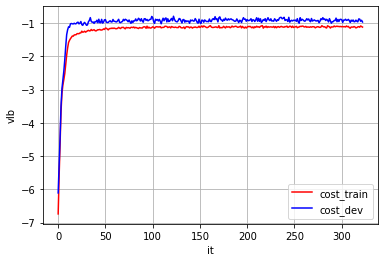

In [14]:
plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_val[:curr_epoch], -1000, 1000), 'b')
plt.legend(['cost_train', 'cost_dev'])
plt.ylabel('vlb')
plt.xlabel('it')
plt.grid(True)
#plt.savefig( str(dname) + '_vlb_lr_' + str(model.lr) + '.png')

## Loading model

In [ ]:
# To check the total number of trainable variables 
"""
total_parameters = 0
for variable in model.trainable_variables:
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    #print(shape)
    #print(len(shape))
    variable_parameters = 1
    for dim in shape:
        #print(dim)
        variable_parameters *= dim
    #print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

time.sleep(10)
"""

## Generate sample parameters

## UNDER VAEAC

In [13]:
class under_VAEAC(tf.keras.Model):
    def __init__(self, base_VAE, width, depth, latent_dim, batch_size, lr, optimizer, save_model = True):
        super(under_VAEAC, self).__init__()
        
        self.base_VAEAC = base_VAE
        self.input_dim = self.base_VAEAC.latent_dim # 8 for default credit
        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim # 6 for default credit
        self.lr = lr
        
        self.prior_encoder = tfd.Normal(loc=tf.zeros(latent_dim), scale=tf.ones(latent_dim))
        
        # self.input_dim is put in a list to make sum(input_dim_vec in recognition_encoder work)
        self.recognition_encoder = create_recognition_encoder(width, depth, latent_dim, [self.input_dim])
        self.decoder = create_decoder(width, depth, latent_dim, [self.input_dim])
        
        self.vlb_scale = 1 / self.input_dim
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.save_model = save_model

    # Inspiration taken from 
    # https://github.com/joocxi/tf2-VAEAC/blob/d2b1bbc258ec77ee0975ea7eb68e63c4efcda6f0/model/vaeac.py

    def reconstruction_loss(self, x, y):
        log_prob_vec = []
        reshape_dim = self.batch_size
        for idx in range(self.input_dim):
            # Gaussian_case
            log_prob_vec.append(tf.expand_dims(-(x[:, idx] - y[:, idx])**2, 1))

        log_prob_vec = tf.reshape(log_prob_vec, [reshape_dim, self.input_dim])
        log_prob_vec = tf.math.reduce_sum(log_prob_vec, axis= -1)
        
        return log_prob_vec
    
def compute_loss_under_VAEAC(model, x_flat, proposal_params_VAEAC):
    
    # Essentially CLUEs normal_parse_params
    proposal_distribution_VAEAC = tfd.Normal(
      loc=proposal_params_VAEAC[..., :model.input_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params_VAEAC[..., model.input_dim:]),
        1e-3,
        tf.float32.max),
      name="proposal")
    
    z_sample = proposal_distribution_VAEAC.sample() # tensor with dim (base_VAEAC.latent_dim,)
    
    proposal_params_VAE = model.recognition_encoder(z_sample) 

    proposal_distribution_VAE = tfd.Normal(
      loc=proposal_params_VAE[..., :model.latent_dim],
      scale=tf.clip_by_value(
        tf.nn.softplus(proposal_params_VAE[..., model.latent_dim:]),
        1e-3,
        tf.float32.max),
      name="priors")

    u_sample = proposal_distribution_VAE.sample() 
    
    rec_params = model.decoder(u_sample) 
    
    # True distribution, Estimated distribution in this order
    kl_divergence = tf.reduce_sum(
      tf.reshape(
        tfd.kl_divergence(proposal_distribution_VAE, model.prior_encoder),
        (model.batch_size, -1)), -1)
    
    rec_loss = model.reconstruction_loss(rec_params, z_sample)
    
    vlb = tf.reduce_mean(-kl_divergence + rec_loss) # For comparing
    loss = tf.reduce_mean((kl_divergence - rec_loss) * model.vlb_scale) 
    return loss, vlb, kl_divergence, rec_loss

@tf.function # Converts all numpy arrays to tensors
def train_step_under_VAEAC(model, x_flat, proposal_params_VAEAC):

    with tf.GradientTape() as tape:
        loss, vlb, kl_divergence, rec_loss = compute_loss_under_VAEAC(model, x_flat, proposal_params_VAEAC)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, vlb, kl_divergence, rec_loss

In [14]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train_VAE(model, x_train, x_test, nb_epochs, early_stop = None):
    
    vlb_train = np.zeros(nb_epochs)
    vlb_val = np.zeros(nb_epochs)
    best_vlb = -np.inf
    best_epoch = 0
    
    overall_batch_size = model.batch_size
    
    test_data = []
    for x in batch(x_test, n = overall_batch_size):
        test_data.append(x)
    
    epoch = 0
    for epoch in range(0, nb_epochs):
        tic = time.time()
        
        train_data = []
        np.random.shuffle(x_train)
        for x in batch(x_train, n = overall_batch_size):
            train_data.append(x)
        
        ## Training
        nb_samples = 0
        for x_batch in train_data:

            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size
            
            # Flatten the batch
            x_batch_flat = gauss_cat_to_flat(x_batch, model.base_VAEAC.input_dim_vec) # numpy
            
            #"""
            x_batch_flat = tf.convert_to_tensor(x_batch_flat)
    
            proposal_params_VAEAC = model.base_VAEAC.recognition_encoder(x_batch_flat) # tensor with dim (16,)
            #"""
            
            loss, vlb, kl_divergence, rec_loss = train_step_under_VAEAC(model, x_batch_flat, proposal_params_VAEAC)

            vlb_train[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_train[epoch] /= nb_samples
        toc = time.time()
        print("Epoch" + str(epoch) + ", vlb: " + str(vlb_train[epoch]) + ", took: " + str(toc-tic))
        
        ## Validation
        nb_samples = 0
        for x_batch in test_data:
            model.batch_size = x_batch.shape[0] # TODO: FIX THIS: Very ugly solution now to make sure batches 
                                                # that do not have the full size
            
            # Flatten the batch
            x_batch_flat = gauss_cat_to_flat(x_batch, model.base_VAEAC.input_dim_vec) # numpy
            
            #"""
            x_batch_flat = tf.convert_to_tensor(x_batch_flat)
    
            proposal_params_VAEAC = model.base_VAEAC.recognition_encoder(x_batch_flat) # tensor with dim (16,)
            #"""
            
            # In CLUE there is actually no difference between eval and fitother than that we should not update the weights.
            # Therefore ok to just call compute_loss_under_VAEAC directly instead of a special eval func
            loss, vlb, kl_divergence, rec_loss = compute_loss_under_VAEAC(model, x_batch_flat, proposal_params_VAEAC)

            vlb_val[epoch] += vlb.numpy() * x_batch.shape[0]
            nb_samples += x_batch.shape[0]

        vlb_val[epoch] /= nb_samples
        
        if vlb_val[epoch] > best_vlb:
            best_vlb = vlb_val[epoch]
            best_epoch = epoch
            if(model.save_model):
                #open text file
                text_file = open("./COMPAS_under_VAEAC/" + str(dname) + "_best_epoch_under_VAEAC_lr_" + str(model.lr) + ".txt", "w")

                #write string to file
                text_file.write(str(epoch))

                #close file
                text_file.close()

                model.recognition_encoder.save("./COMPAS_under_VAEAC/" + str(dname) + "_under_recog_encoder_lr_" + str(model.lr))
                model.decoder.save("./COMPAS_under_VAEAC/" + str(dname) + "_under_decoder_lr_" + str(model.lr))

        print("Validation vlb: " + str(vlb_val[epoch]) + ", Best vlb: " + str(best_vlb) + "\n")

        if early_stop is not None and (epoch - best_epoch) > early_stop:
            print("Early stopping triggered")
            break
    
    np.save("./COMPAS_under_VAEAC/" + str(dname) + "_under_vlb_train_lr_" + str(model.lr), vlb_train)
    np.save("./COMPAS_under_VAEAC/" + str(dname) + "_under_vlb_val_lr_" + str(model.lr), vlb_val)
    return vlb_train, vlb_val, best_epoch, best_vlb, epoch




In [15]:
# For Default credit
"""
input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1, 2]
width = 350
depth = 3
latent_dim = 8
num_examples_to_generate = 16

batch_size = 128
nb_epochs = 2000 # 2000
early_stop = 200
lr = 1e-4        # Maybe this should be 1e-4, but it makes the performance terrible...

x_train, x_test, x_means, x_stds = \
load_UCI(dset_name=dname, splits=10, seed=42, separate_targets=False, save_dir='../data/') # np.arrays

x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec) # np.array
x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec) 
"""

# For COMPAS
#"""
dname = 'compas'
print(dname)

input_dim_vec = [3, 6, 2, 2, 2, 1, 1, 2]
batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4
width = widths[names.index(dname)] # 350
depth = depths[names.index(dname)] # number of hidden layers # 3
latent_dim = latent_dims[names.index(dname)] # 4

x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')

x_train, x_test, input_dim_vec = join_compas_targets(x_train, x_test, y_train, y_test, X_dims)

print('Compas', x_train.shape, x_test.shape)
print(input_dim_vec)
#"""

optimizer_VAEAC = tfa.optimizers.RectifiedAdam(lr= lr , epsilon=1e-8)

# Create new model to load in weightsinto that can then continued to be trained
model2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = True)

model2.recognition_encoder = keras.models.load_model("./COMPAS_VAEAC/compas_recog_encoder_lr_0.0001")
model2.prior_encoder = keras.models.load_model("./COMPAS_VAEAC/compas_prior_encoder_lr_0.0001")
model2.decoder = keras.models.load_model("./COMPAS_VAEAC/compas_decoder_lr_0.0001")


# No mask is used to train the 2nd lvl VAE
#masker = top_masker_tensorflow(p=1)

base_network = model2
width = 150
depth = 2
latent_dim = under_latent_dims[names.index(dname)]

batch_size = 128
nb_epochs = 2000
early_stop = 200
lr = 1e-4

optimizer_under_VAEAC = tfa.optimizers.RectifiedAdam(lr = lr, epsilon = 1e-8)

under_VAEAC_net = under_VAEAC(base_network, width, depth, latent_dim, batch_size, lr, \
                              optimizer_under_VAEAC, save_model = True)

vlb_train, vlb_val, best_epoch, best_vlb, curr_epoch = train_VAE(under_VAEAC_net, x_train, x_test, nb_epochs, early_stop=early_stop)



compas
Compas (5554, 19) (618, 19)
[3 6 2 2 2 1 1 2]


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2021-12-09 08:14:35.983787: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 08:14:39.583222: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch0, vlb: -11.87457807449544, took: 5.396807909011841
Validation vlb: -11.647859098070262, Best vlb: -11.647859098070262

Epoch1, vlb: -11.46009496462873, took: 0.7050871849060059
Validation vlb: -11.280903269943682, Best vlb: -11.280903269943682

Epoch2, vlb: -10.796587539483284, took: 0.6516151428222656
Validation vlb: -10.587609889823643, Best vlb: -10.587609889823643

Epoch3, vlb: -10.329865588873979, took: 0.8168058395385742
Validation vlb: -10.162653509467166, Best vlb: -10.162653509467166

Epoch4, vlb: -9.68864701675948, took: 0.7665059566497803
Validation vlb: -9.435937813570584, Best vlb: -9.435937813570584

Epoch5, vlb: -9.103045261975112, took: 0.9943850040435791
Validation vlb: -8.907617038121886, Best vlb: -8.907617038121886

Epoch6, vlb: -8.547457183656565, took: 0.8868169784545898
Validation vlb: -8.651977341537723, Best vlb: -8.651977341537723

Epoch7, vlb: -7.828872829192742, took: 0.7899839878082275
Validation vlb: -7.683699603219634, Best vlb: -7.683699603219634



Epoch66, vlb: -4.4116613836566625, took: 0.6807680130004883
Validation vlb: -4.4113454618114485, Best vlb: -4.258453893815815

Epoch67, vlb: -4.366206982516109, took: 0.6651320457458496
Validation vlb: -4.393482131093837, Best vlb: -4.258453893815815

Epoch68, vlb: -4.445198648560592, took: 0.6770241260528564
Validation vlb: -4.2117198107697815, Best vlb: -4.2117198107697815

Epoch69, vlb: -4.375985882374121, took: 0.6772909164428711
Validation vlb: -4.417117487651245, Best vlb: -4.2117198107697815

Epoch70, vlb: -4.398749639286512, took: 0.6631197929382324
Validation vlb: -4.372707519716429, Best vlb: -4.2117198107697815

Epoch71, vlb: -4.3935899787727, took: 0.6481359004974365
Validation vlb: -4.402967252391828, Best vlb: -4.2117198107697815

Epoch72, vlb: -4.414402947307363, took: 0.7378270626068115
Validation vlb: -4.379942097710174, Best vlb: -4.2117198107697815

Epoch73, vlb: -4.399346081524562, took: 0.6562709808349609
Validation vlb: -4.332456701395967, Best vlb: -4.21171981076

Epoch131, vlb: -4.3527545192321515, took: 0.6603426933288574
Validation vlb: -4.284350361253066, Best vlb: -4.2117198107697815

Epoch132, vlb: -4.322032071636613, took: 0.671781063079834
Validation vlb: -4.307039959916791, Best vlb: -4.2117198107697815

Epoch133, vlb: -4.331656520728117, took: 0.653810977935791
Validation vlb: -4.347257143471233, Best vlb: -4.2117198107697815

Epoch134, vlb: -4.326041698112392, took: 0.6653330326080322
Validation vlb: -4.436149364150458, Best vlb: -4.2117198107697815

Epoch135, vlb: -4.371186492680902, took: 0.6680779457092285
Validation vlb: -4.397863341766653, Best vlb: -4.2117198107697815

Epoch136, vlb: -4.343921754100059, took: 0.6617050170898438
Validation vlb: -4.41014367477022, Best vlb: -4.2117198107697815

Epoch137, vlb: -4.3736996563123975, took: 0.6838998794555664
Validation vlb: -4.4062405789940104, Best vlb: -4.2117198107697815

Epoch138, vlb: -4.316483376907882, took: 0.6536650657653809
Validation vlb: -4.427131566414941, Best vlb: -4.21

Epoch196, vlb: -4.319963469967209, took: 0.6646640300750732
Validation vlb: -4.396641478183586, Best vlb: -4.2117198107697815

Epoch197, vlb: -4.3265764241944895, took: 0.6492860317230225
Validation vlb: -4.372824437409928, Best vlb: -4.2117198107697815

Epoch198, vlb: -4.300621580811426, took: 0.6487069129943848
Validation vlb: -4.304592744432221, Best vlb: -4.2117198107697815

Epoch199, vlb: -4.339559602703085, took: 0.6502058506011963
Validation vlb: -4.3023420799897325, Best vlb: -4.2117198107697815

Epoch200, vlb: -4.365684978215867, took: 0.6549088954925537
Validation vlb: -4.310039307307271, Best vlb: -4.2117198107697815

Epoch201, vlb: -4.309328633845174, took: 0.6578559875488281
Validation vlb: -4.429527929299858, Best vlb: -4.2117198107697815

Epoch202, vlb: -4.36026374272919, took: 0.6560900211334229
Validation vlb: -4.3517907244487875, Best vlb: -4.2117198107697815

Epoch203, vlb: -4.328513423616095, took: 0.6594529151916504
Validation vlb: -4.273093234373913, Best vlb: -4.

Epoch261, vlb: -4.316840296303321, took: 0.6580290794372559
Validation vlb: -4.352828073655903, Best vlb: -4.2117198107697815

Epoch262, vlb: -4.364917336499301, took: 0.6608402729034424
Validation vlb: -4.395222998745619, Best vlb: -4.2117198107697815

Epoch263, vlb: -4.325177434798321, took: 0.6520540714263916
Validation vlb: -4.242438415107603, Best vlb: -4.2117198107697815

Epoch264, vlb: -4.343286157298269, took: 0.6584420204162598
Validation vlb: -4.331316225737044, Best vlb: -4.2117198107697815

Epoch265, vlb: -4.337517446264501, took: 0.6577877998352051
Validation vlb: -4.268645820494223, Best vlb: -4.2117198107697815

Epoch266, vlb: -4.248979257343912, took: 0.664417028427124
Validation vlb: -4.372772047049019, Best vlb: -4.2117198107697815

Epoch267, vlb: -4.317908653648027, took: 0.673408031463623
Validation vlb: -4.313725712229904, Best vlb: -4.2117198107697815

Epoch268, vlb: -4.326522042092806, took: 0.6762478351593018
Validation vlb: -4.557080629959847, Best vlb: -4.2117

In [17]:
input_dim_vec_X_dims = X_dims_to_input_dim_vec(X_dims)
print(input_dim_vec_X_dims)
print(input_dim_vec)

[3 6 2 2 2 1 1]
[3 6 2 2 2 1 1 2]


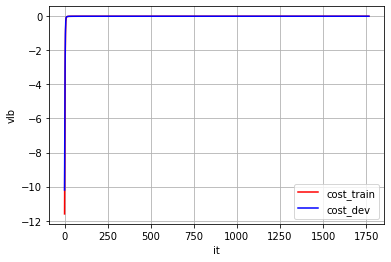

In [16]:
plt.figure()
plt.plot(np.clip(vlb_train[:curr_epoch], -1000, 1000), 'r')
plt.plot(np.clip(vlb_val[:curr_epoch], -1000, 1000), 'b')
plt.legend(['cost_train', 'cost_dev'])
plt.ylabel('vlb')
plt.xlabel('it')
plt.grid(True)
#plt.savefig( str(dname) + '_vlb_lr_' + str(model.lr) + '.png')

In [16]:
#"""
total_parameters = 0
for variable in under_VAEAC_net.trainable_variables:
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    #print(shape)
    #print(len(shape))
    variable_parameters = 1
    for dim in shape:
        #print(dim)
        variable_parameters *= dim
    #print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

time.sleep(10)
#"""

827897


In [18]:
#print(under_VAEAC_net.trainable_variables)

In [19]:
#print(model2.decoder.summary())

In [26]:
# TO check the that the parameters in the VAEAC are not trained during the training of under_VAEAC

# Encoder
#print(model2.recognition_encoder.trainable_variables[0])

# Decoder
#print(model2.decoder.trainable_variables[0])

In [27]:
# Encoder
"""
model2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = True)
model2.recognition_encoder = keras.models.load_model("./COMPAS_VAEAC/compas_recog_encoder_lr_0.0001")
print(model2.recognition_encoder.trainable_variables[0])
"""

# Decoder
"""
model2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = True)

model2.decoder = keras.models.load_model("./COMPAS_VAEAC/compas_decoder_lr_0.0001")

print(model2.decoder.trainable_variables[0])
"""


'\nmodel2 = VAEAC_gauss_cat(width, depth, latent_dim, input_dim_vec, batch_size, lr, optimizer_VAEAC, save_model = True)\n\nmodel2.decoder = keras.models.load_model("./COMPAS_VAEAC/compas_decoder_lr_0.0001")\n\nprint(model2.decoder.trainable_variables[0])\n'

In [22]:
#print(model2.prior_encoder.summary())

In [23]:
#print(under_VAEAC_net.decoder.summary())

In [24]:
#print(under_VAEAC_net.recognition_encoder.summary())

In [ ]:
### Currently Working on ###

### TODO ###

# Make code work for only continous data (GaussianLogLike?)

# Train VAEAC (default credit) using 7e-4 lr and save the model

# Clean up the code

## eval/training mode things ##

# Verify if BatchNorm does what it should when training = True/False is not sent into the model

# Do I need to set the models to eval mode and not training during validation data or does tf handle this?
    # Apparently batchnorm layers do different things during training/evaluation
    # Adding training = True affects a lot..., it is not enabled by default during train_step gradient.
    # Setting training = True in eval affects the training_VAE still. 
    # Not using training = True/False makes the model work well, 
    # Question is if BatchNorm does the correct thing during eval

##---------------------------##


## Ask Ali if 
    # His network has the correct structure (The decoder was wrong for VAEAC)
    # He has thought of initlialisations
    # hyperparameters, bias, epsilon, momentum etc.

# Skip connections from prior to decoder? I don't think CLUE got this to work properly...
    # Memory layer is used in Tf2 github

# Not sure what the TF equivalence of affine and track_running_stats is in Torch BatchNorm1D 
    
# Why does train_step only print things inside it twice for the first batch and then never for any other batch?
    
### TO IMPLEMENT ###


### DONE ###
"""

√ under_VAEAC updates the VAEAC recognition_encoder parameters. Need to freeze them somehow...
    # Maybe calculate proposal_params_VAEAC before calling train_step_under_VAEAC to make it work?
    # Yup, that did the trick

√ Something wrong with the number of trainable parameters in my under_VAEAC? Seems to be way more than in Torch?
    # The VAEAC recognition_encoder was being trained in under_VAEAC

√ Make VAEAC work for COMPAS
    # How to load COMPAS?

√ Train the VAEAC for COMPAS

√ Fix the under_VAEAC code  (i.e. get eval to work there just as in VAEAC)

√ update_train VAE with the train_VAEAC code (Add Shuffle among many things)

√ Plot the loss graph over train and validation set

√ Save the vlb_train & vlb_val after training

√ rec_los: Should the target not be flattened but instead just x_batch?
    # Don't think so, the final values look fairly similar.
    # I think it is fine since the program seems to be doing what it should

√ How do the batches work in the network? How can we send a 64x31 batch to encoder? It should only take 31 as input
    # the keras.input((31, )) means it expect features with dimension 31 and unspecified batch_size. 
    # When a batch with 64,31 size comes it in will treat each row as a sample

√ Should I have 7e-4 or 1e-4 learning rate?
    # 7e-4 for comparing and making sure the model works as intended but 1e-4 for the real training

√ Remove reparametrize?

√ Add lr to print epoch in VAEAC training

√ Is something wrong with the trainable variables? Should I before training use tf.Variable to make them trainable?
    # https://www.tensorflow.org/api_docs/python/tf/Variable
    # Seems right, it is the exact same amount of trainable parameters in torch and tf

√ Have I forgotten to do a tf.reduce_sum over regularisation? 
    # Don't think so... their sum(-1) on reg_cost does nothing

√ Something might be wrong with how the training is done with batches... 
    # Probably not, input(shape,) makes it so that it expects one dimension to be of shape 
    # without specifying the batch size

√ vlb_val is calculated using eval not fit

√ Add shuffling of the training data 

√ Verify the number of trainable parameters in CLUE vs TF 
    # Exact same amount for under_VAEAC and VAEAC

√ implement under_VAEAC vlb (MSELoss and KL-divergence)

√ rsample instead of sample? (rsample for derivatives in torch, tf does not care)

√ Save the model during training (best vlb)

√ Fix so that training with 2nd lvl VAE is done without the mask

√ 1e-4 can at times get very poor vlb at the start but then recover. Why is this?   
    # Seems to have been solved by initialising the dense weights and bias weights the same way as Torch
    # I get like -19 or -20, -22 every single first epoch now

√ Validation vlb not low enough? 
    # Not terrible but indeed not as low, seems to go towards the right values at least but it happens slowly

√ Need to initialise the weights in keras dense for the neurons and bias the same way as nn.linear

√ Need to make the layers in a skip connection sequential? nn.sequential in torch
    # The russian doll effect does exactly this!
    
√ What activation is used in dense/nn.linear?
    # None
    
√ Is keras dense and torch nn.linear the same thing?
    # How are the weights inited in each? (Different ways by default but I made them init the same way)
    # They are basically the same, input to neural network nodes (bias = True add a bias node)
    # Google images for keras dense and nn.linear and you see that it is just a normal feed forward process.
"""